# Setup

In [1239]:
#!/usr/bin/env python3
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

plt.style.use(["science", "nature", "notebook"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Computer", "Noto Serif CJK jp"],
        "font.size": 11,
        "text.usetex": False,
        "mathtext.fontset": "stixsans",
        "figure.figsize": (5, 3),
    }
)

from prep import *
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import statsmodels.formula.api as smf
import seaborn as sns
import functools

df = pd.read_csv("../data/viz_learn_preds.csv", index_col=0)


def linear_model(formula, df, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    preds = results.predict(df)
    targs = df[targ]
    if model_name is None:
        model_name = formula.format(targ)
    fig, annot = plot_regression_once(preds, targs, model_name)
    return results, fig


@functools.lru_cache
def lm(formula, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    return results


def set_base(ser, base):
    cats = list(ser.unique())
    idx = cats.index(base)
    cats[idx] = cats[0]
    cats[0] = base
    return pd.Categorical(ser, categories=cats)

In [1240]:
df["station"] = set_base(df["station"], "ＪＲ山手線/浜松町駅")
df["method"] = set_base(df["method"], "歩")
df["apt_style"] = df["apt_style"].apply(apt_style_clean)
df["time_to_station_sq"] = df["time_to_station"] ** 2
df["apt_style"] = set_base(df["apt_style"], "ワンルーム")
# df = df[df["valid"]]

In [1241]:
corr = df[["log_apt_rent","viz_preds", "b_age", "apt_size", "b_no_floors", "apt_floor", "apt_admin_price", "time_to_station"]].corr()
names = {
    "apt_size": r"Apt Size($ m^2 $)",
    "b_no_floors": "B. No. Floors",
    "b_age": "B. Age",
    "apt_floor": "Apt Floor",
    "apt_admin_price": "Admin Fee",
    "time_to_station" : "T. t. station",
    "viz_preds": 'NN factor',
    "log_apt_rent": "log(rent)"
}
corr = corr.rename(names, axis=1).rename(names, axis=0)

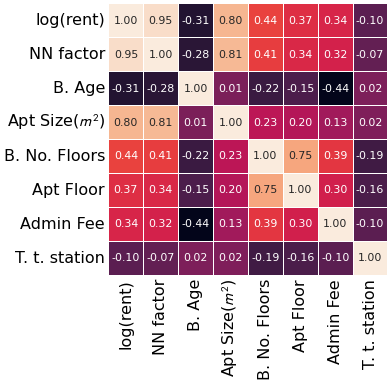

In [1242]:
mpl.rc('text', usetex = False)

plt.figure(figsize=(5, 5))
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False, right=False
    ) 

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, linewidths=0.5, cbar=False,fmt=".2f", annot_kws={"fontsize": "11"} )
plt.savefig("../../paper/assets/corrplot.png",bbox_inches="tight", dpi=300,transparent=False)

In [1243]:
mod1 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style",
    # "+ viz_preds",
    "log_apt_rent",
    model_name="Without NN",
)
mod2 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style"
    "+ viz_preds",
    "log_apt_rent",
    model_name="With NN",
)

mod3 = lm(
    "{} ~ viz_preds", 
    "log_apt_rent",
    model_name="Only NN"
)


# Stargazer

In [1244]:
from stargazer.stargazer import Stargazer, LineLocation
def latex_format(name, cap):
    template = "\n\caption{{\label{{{}}}{}}}\n"
    return template.format(name, cap)
    
        
sg = Stargazer([mod1, mod2, mod3])
def de_free(mod):
    return sg.extract_model_data(mod)["degree_freedom"]

styles = list(filter(lambda x: x.startswith("apt_style"), sg.cov_names))

order = [
    "Intercept",
    "apt_size",
    "b_age",
    "b_no_floors",
    "apt_floor",
    "apt_admin_price",
    "time_to_station",
    "time_to_station_sq",
    "viz_preds"
] #+ styles

sg.covariate_order(order)

sg.rename_covariates({
    "apt_size": "Apartment Size(\(m^2\))",
    "b_no_floors": "No. Floors(Building)",
    "b_age": "Building age",
    "apt_floor": "Apartment Floor",
    "apt_admin_price": "Administration Price",
    "time_to_station" : "Time to station",
    "time_to_station_sq": "Time to station\(^2\)",
    "viz_preds": 'NN Factor',
})
sg.add_line('Degrees of Freedom', [de_free(mod1), de_free(mod2), de_free(mod3)], LineLocation.FOOTER_TOP)
sg.custom_columns(['1) Without NN', '2) With NN', "3) Only NN"], [1, 1, 1])
sg.show_model_numbers(False)
sg.add_custom_notes([''])
sg.dependent_variable_name("Dependent variable: \( log(apt\_rent) \)")
sg.show_degrees_of_freedom(False)
sg.dependent_variable = ""

In [1245]:
sg

In [1246]:
tab_file="../../paper/assets/table2.tex" 
with open(tab_file, "w") as f:
    f.write(sg.render_latex())

In [1247]:
# \caption{\label{tab:var_explanation}An explanation of the variables that were collected and used in this study.}
cap = """Esimated coefficients (Standard Erorrs) for the variables in Table \\ref{tab:var_explanation}.
These coefficients were estimated with the hedonic price model explained. However, because of the high cardinality 
of the categorical variables of Apartment style and closest station, we excluded the two variables here.
"""
name = "tab:regression"
capstring = latex_format(name, cap) 

def write_label(capstring, tab_file, write=True, resize=False):
    if resize:
        capstring= capstring + "\\resizebox{\columnwidth}{!}{%\n"
    outstring=""
    with open(tab_file, "r") as f:
        outstring = (f" {capstring} ".join(f.readline().split(" ")))
        outstring += f.read()
    if resize:
        outstring = "\end{tabular}%\n}".join(outstring.split(r"\end{tabular}"))
    if write:
        with open(tab_file, "w") as f:
            f.write(outstring)
    else:
        print(outstring)

write_label(capstring, tab_file, write=True)

# Looking at predictions

In [1248]:
import os 
from PIL import Image
from pathlib import Path
from IPython.display import Image
from IPython.display import display
import matplotlib.image as mplimg


In [1249]:
root =  Path("/Users/jiyanschneider/Dropbox/scraper/imgs/")
def image_path(f, path=root):
    return mplimg.imread(path / f)


In [1250]:
df["exp_viz_preds"] = np.exp(df["viz_preds"])
df["exp_viz_targs"] = np.exp(df["viz_targs"])
   

In [1251]:
df["station"].unique()

['ＪＲ山手線/浜松町駅', '都営大江戸線/汐留駅', '東京メトロ銀座線/溜池山王駅', '東急池上線/石川台駅', '東京メトロ千代田線/千駄木駅', ..., '都営バス/新小岩駅北口', '国際興業バス/小豆沢２丁目', '千01/千住中居町', '都営大江戸線/練馬春日町駅', '北01/いずみ記念病院前']
Length: 684
Categories (684, object): ['ＪＲ山手線/浜松町駅', '都営大江戸線/汐留駅', '東京メトロ銀座線/溜池山王駅', '東急池上線/石川台駅', ..., '国際興業バス/小豆沢２丁目', '千01/千住中居町', '都営大江戸線/練馬春日町駅', '北01/いずみ記念病院前']

In [1252]:
def show_imgs(l, title=None, **kwargs):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, pred, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{pred:.2f}/{actual:.2f}")
    if not title:
        plt.suptitle("Prediction/Actual", fontsize=20)
    else:
        plt.suptitle(title, fontsize=20)
    return fig

def show_pred_imgs(l, **kwargs):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, mod1, mod2, NN, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{mod1:.2f}/{mod2:.2f}/{NN:.2f}/{actual:.2f}")
    plt.suptitle("Model1/Model2/NN/Actual", fontsize=20)
    return fig


def image_triple(idxs, exp=True):
    if exp:
        return list(df[["rel_image_paths", "exp_viz_preds", "exp_viz_targs"]].loc[idxs].to_records(index=False))
    else: 
        return list(df[["rel_image_paths", "viz_preds", "viz_targs"]].loc[idxs].to_records(index=False))

def pred_tup(idxs, cols):
    return list(df[["rel_image_paths", *cols]].loc[idxs].to_records(index=False))
        

def random_images(N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    rands = list(np.random.randint(0, len(df), size=N))
    return image_triple(rands)



## Random predictions

In [1253]:
random_images(5)

[('full/198ddaf36081c0463ed7b137bf48370018c8e9a4.jpg', 20.09794357, 21.09999915),
 ('full/1a93aa53bbf479ebea91004bbaa5b2342e7f9f39.jpg', 8.26446253, 6.89999992),
 ('full/e7befd6a91ff2d4617be7ab3a2f133d9ceaf829f.jpg', 11.30507455, 10.00000007),
 ('full/b43451a85e074e51dcd955a8e2e9f2ab9b7720e2.jpg', 13.13411443, 10.19999979),
 ('full/9055d9305af99df350f9f167c0bd1a3166e79d57.jpg', 7.07937552, 6.89999992)]

In [1254]:
dpi=150

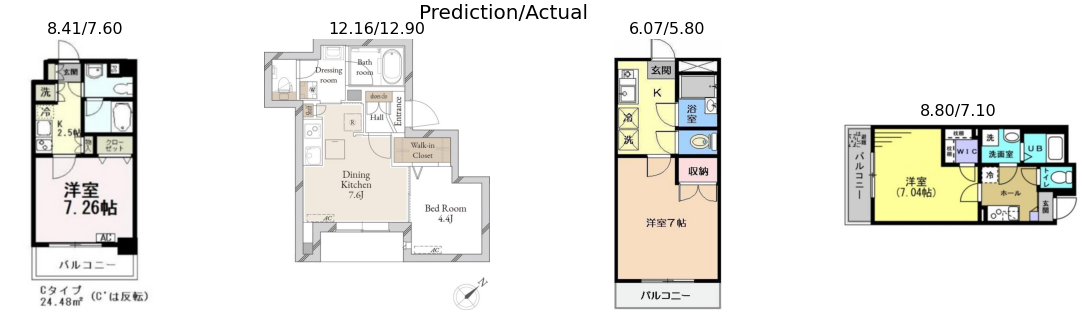

In [1255]:
x = show_imgs(random_images(4, seed=2021), figsize=(20, 5))
x.savefig("../../paper/assets/random_table.png", dpi=dpi)

In [1256]:
from fastcore.all import L

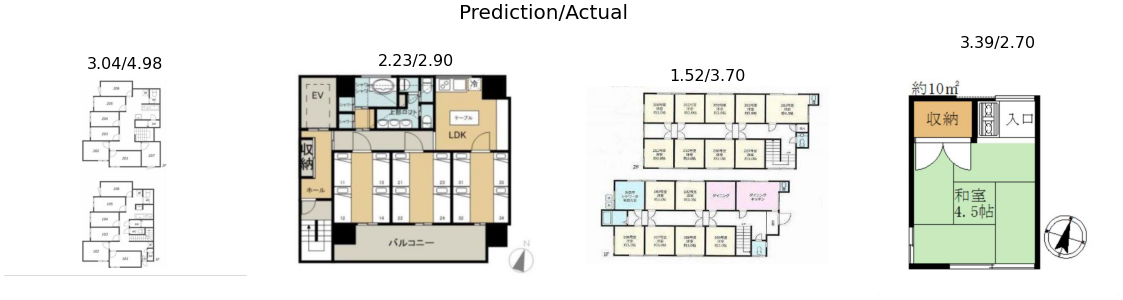

In [1257]:
M = 100
N = 12
highest_idx = L(df.sort_values("viz_preds").index.to_list()[:M])
np.random.seed(41)
rands = highest_idx[list(np.random.randint(0, M, 4))]
x = show_imgs(image_triple(rands), figsize=(20, 5))
x.savefig("../../paper/assets/random_negtop100.png", dpi=dpi)

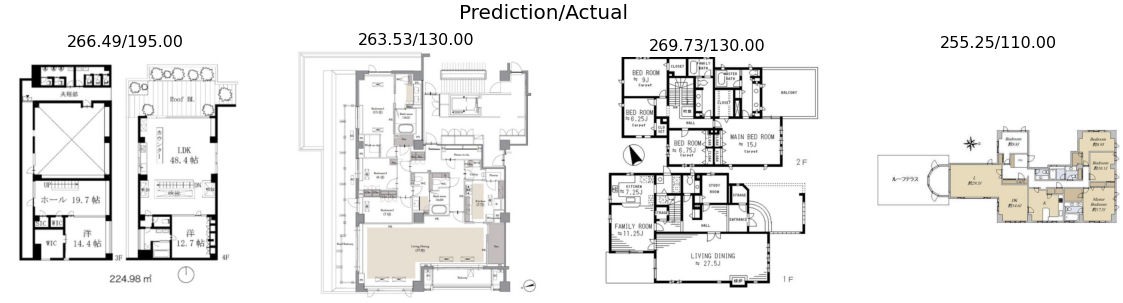

In [1258]:
highest_idx = L(df.sort_values("viz_preds", ascending=False).index.to_list()[:M])
np.random.seed(49)
rands = highest_idx[list(np.random.randint(0, M, 4))]
x = show_imgs(image_triple(rands), figsize=(20, 5))
x.savefig("../../paper/assets/rand_top_100.png", dpi=dpi)

In [1259]:
np.exp(6)

403.4287934927351

In [1260]:
df["mod1preds"] = mod1.predict(df)
df["mod2preds"] = mod2.predict(df)
df["exp_mod1preds"] = np.exp(df["mod1preds"])
df["exp_mod2preds"] = np.exp(df["mod2preds"])

In [1261]:
mistakes = (df["mod1preds"] - df["mod2preds"]).sort_values()

In [1262]:
underestimates = mistakes[:4].index.to_list()
overestimates = mistakes[-10:-5].index.to_list()

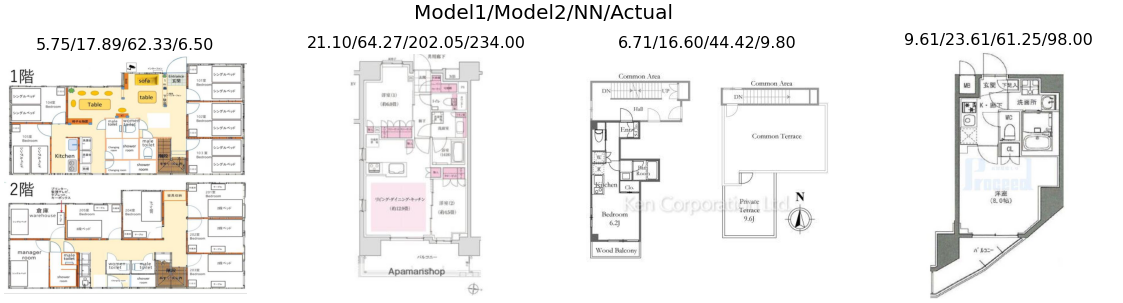

In [1263]:
x = show_pred_imgs(pred_tup(underestimates, ("exp_mod1preds", "exp_mod2preds","exp_viz_preds", "exp_viz_targs")),figsize=(20, 5))
x.savefig("../../paper/assets/underpreds.png", dpi=dpi)

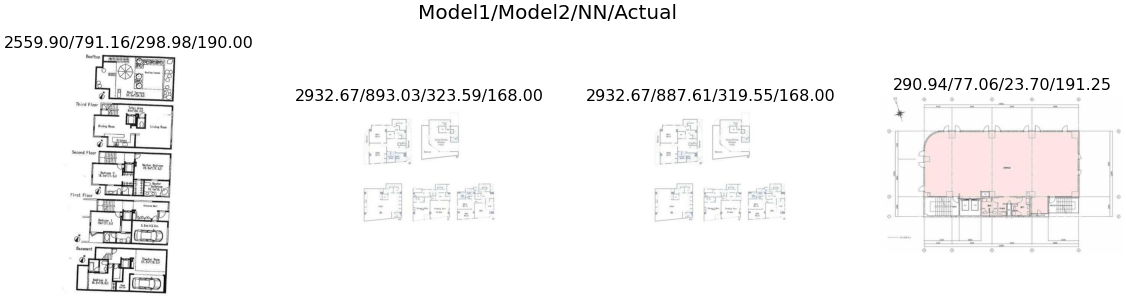

In [1264]:
x = show_pred_imgs(pred_tup(overestimates, ("exp_mod1preds", "exp_mod2preds","exp_viz_preds", "exp_viz_targs")),figsize=(20, 5))
x.savefig("../../paper/assets/overpreds.png", dpi=dpi)

In [1265]:
df["exp_viz_targs"].max()

250.00002053443933

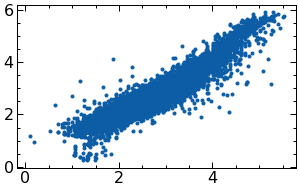

In [1266]:
plt.scatter(df["viz_targs"], df["viz_preds"])

In [1267]:
df["valid"]

0          True
1         False
2         False
3         False
4         False
          ...  
141389    False
141390    False
141391     True
141392     True
141393    False
Name: valid, Length: 141394, dtype: bool

In [1268]:
((df[df["valid"]]["viz_preds"] - df[df["valid"]]["viz_targs"])**2).mean()

0.03420798895859065

# Summary stats

In [1269]:
cont = ["b_age", "b_no_floors", "apt_size", "apt_rent", "apt_admin_price", "apt_floor", "time_to_station"]
df[cont].describe().T

,count,mean,std,min,25%,50%,75%,max
b_age,141394.0,17.701062,15.081147,0.00,4.00,15.0,30.0,99.00
b_no_floors,141394.0,7.300168,5.734189,1.00,3.00,6.0,10.0,60.00
apt_size,141394.0,30.497512,17.251406,1.94,21.16,25.6,35.0,491.88
apt_rent,141394.0,11.119562,8.232117,1.10,7.50,9.1,12.1,250.00
apt_admin_price,141394.0,6554.481350,5220.711042,0.00,3000.00,6000.0,10000.0,220600.00
apt_floor,141394.0,4.096327,3.610408,1.00,2.00,3.0,5.0,57.00
time_to_station,141394.0,6.034167,3.284996,1.00,4.00,5.0,8.0,40.00


In [1270]:
df.describe(include="category").T#.to_latex())

,count,unique,top,freq
apt_style,141394,31,1K,63573
station,141394,684,東京メトロ東西線/葛西駅,1839
method,141394,3,歩,140329


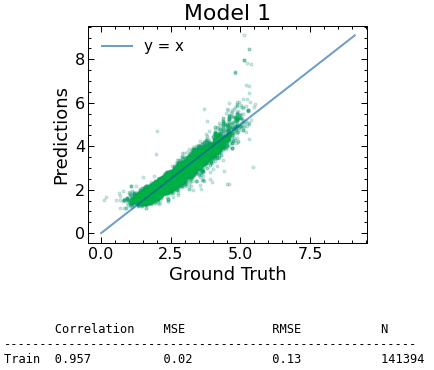

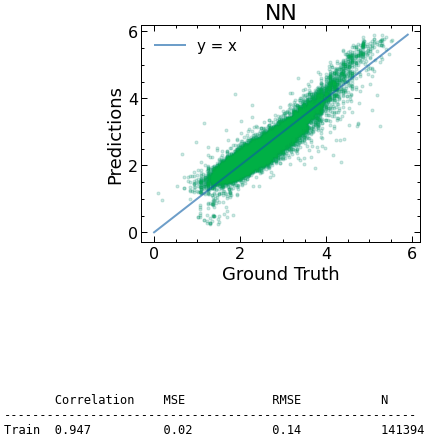

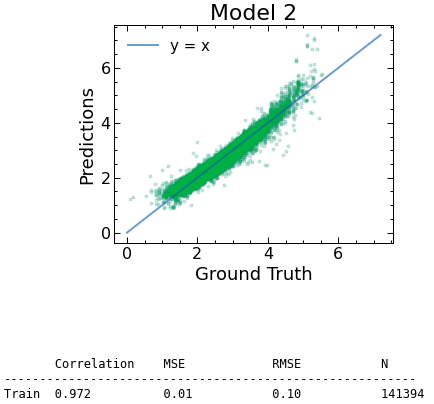

In [1271]:
p1, s = plot_regression_once(df["mod1preds"], df["viz_targs"], model_name="Model 1")
pnn, s = plot_regression_once(df["viz_preds"], df["viz_targs"], model_name="NN")
p2, s = plot_regression_once(df["mod2preds"], df["viz_targs"], model_name="Model 2")

In [1281]:
from collections import namedtuple
Stats = namedtuple("Stats", ["corr", "mse", "rmse", "N"])

def plot_model_summary(preds, targs, model_name, ax):
    targs = pd.Series(targs).reset_index(drop=True)
    preds - pd.Series(preds).reset_index(drop=True)
    m_se = mean_squared_error(preds, targs)
    trainstats = Stats(
        mse=m_se,
        rmse=np.sqrt(m_se),
        N=preds.shape[0],
        corr=preds.corr(targs),
    )
    ax.scatter(x=targs, y=preds, alpha=0.10)
    ax.scatter(x=targs, y=preds, alpha=0.10)
    m = max(targs.max(), preds.max())
    ax.plot([0, 8], [0, 8], label="y = x", alpha=0.6)
    ax.set_xlim((0, 8))
    ax.set_ylim((0, 8))
    ax.set_xlabel("Actual")
    ax.axvline(np.log(100), linestyle="dotted")
    # ax.legend(fontsize=15)
    # ax.ylabel("Predictions", fontsize=18)
    # ax.xlabel("Ground Truth", fontsize=18)
    ax.set_title(f"{model_name}", fontsize=22)
    return ax

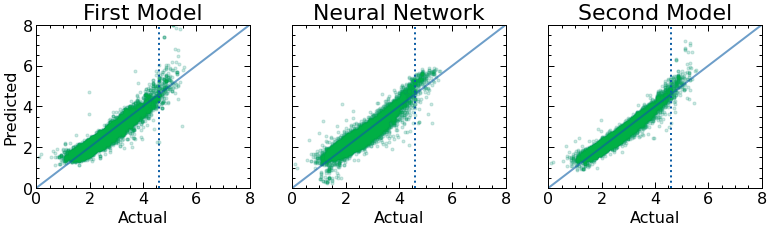

In [1282]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13, 3) )
plot_model_summary(df["mod1preds"], df["viz_targs"], "First Model", axs[0])
plot_model_summary(df["viz_preds"], df["viz_targs"], "Neural Network", axs[1])
plot_model_summary(df["mod2preds"], df["viz_targs"], "Second Model", axs[2])
axs[0].set_ylabel("Predicted")
plt.savefig("../../paper/assets/residual_plot.png", dpi=dpi)

# axs[0].scatter(df["viz_preds"], df["viz_targs"])